# Etiquetado de T√≥picos Predefinidos con LLM Multi-Etiqueta

Este notebook implementa un sistema de clasificaci√≥n multi-etiqueta para rese√±as tur√≠sticas utilizando un LLM con salida estructurada. El objetivo es etiquetar cada rese√±a con categor√≠as predefinidas para posteriormente entrenar modelos BERT o similares.

## Import Required Libraries

In [1]:
import pandas as pd
from typing import List
from pydantic import BaseModel, Field, validator
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
import time
import os

## Setup LLM and Pydantic Models

In [2]:
# Configuraci√≥n de modelos LLM - Control granular de procesamiento
MODELS_BASIC = ["gpt-4.1-mini", "gpt-4o-mini"]  # Modelos con enfoque b√°sico (solo etiquetas)
MODELS_JUSTIFIED = ["gpt-5-nano"]  # Modelos con enfoque justificado (etiquetas + justificaciones)

# Control de qu√© modelos re-etiquetar (cambia a True para forzar re-etiquetado)
MODELS_TO_RELABEL = {
    "gpt-4.1-mini": False,    # Cambiar a True si quieres re-etiquetar
    "gpt-4o-mini": False,     # Cambiar a True si quieres re-etiquetar  
    "gpt-5-nano": True        # Cambiar a True si quieres re-etiquetar
}

# ========== CONFIGURACI√ìN PARA ENFOQUE B√ÅSICO (Solo Etiquetas) ==========
class MultiLabelOutput(BaseModel):
    labels: List[int] = Field(..., description="Lista de n√∫meros de categor√≠as aplicables (0-13)")
    
    @validator('labels')
    def validate_labels(cls, v):
        valid_labels = set(range(14))  # Ahora 0-13
        
        if not all(label in valid_labels for label in v):
            raise ValueError("Todas las etiquetas deben estar entre 0 y 13")
        
        # Manejo autom√°tico de la categor√≠a 13 (Otros) cuando aparece con otras etiquetas
        if 13 in v and len(v) > 1:
            # Si la categor√≠a 13 aparece con otras, la removemos autom√°ticamente
            # ya que las otras categor√≠as son m√°s espec√≠ficas
            v_filtered = [label for label in v if label != 13]
            print(f"‚ö†Ô∏è Categor√≠a 13 removida autom√°ticamente. Etiquetas finales: {v_filtered}")
            return sorted(list(set(v_filtered)))
        
        return sorted(list(set(v)))

# ========== CONFIGURACI√ìN PARA ENFOQUE JUSTIFICADO (Etiquetas + Justificaciones) ==========
class LabelWithJustification(BaseModel):
    label_id: int = Field(..., description="ID de la categor√≠a (0-13)")
    label_name: str = Field(..., description="Nombre de la categor√≠a")
    justification: str = Field(..., description="Cita textual que justifica esta etiqueta")

class JustifiedMultiLabelOutput(BaseModel):
    classified_labels: List[LabelWithJustification] = Field(..., description="Lista de etiquetas asignadas con sus justificaciones")
    
    @validator('classified_labels')
    def validate_labels(cls, v):
        # Validar que los IDs est√©n en rango v√°lido
        valid_labels = set(range(14))
        for item in v:
            if item.label_id not in valid_labels:
                raise ValueError(f"Label ID {item.label_id} debe estar entre 0 y 13")
        
        # Manejo autom√°tico de la categor√≠a 13 (Otros)
        if len(v) > 1 and any(item.label_id == 13 for item in v):
            # Si hay categor√≠a 13 con otras, remover la 13
            v_filtered = [item for item in v if item.label_id != 13]
            print(f"‚ö†Ô∏è Categor√≠a 13 removida autom√°ticamente por tener otras categor√≠as m√°s espec√≠ficas")
            return v_filtered
        
        return v

print("‚úÖ Configuraci√≥n de modelos actualizada:")
print(f"   ‚Ä¢ Modelos b√°sicos: {MODELS_BASIC}")
print(f"   ‚Ä¢ Modelos justificados: {MODELS_JUSTIFIED}")
print(f"   ‚Ä¢ Control de re-etiquetado: {MODELS_TO_RELABEL}")

‚úÖ Configuraci√≥n de modelos actualizada:
   ‚Ä¢ Modelos b√°sicos: ['gpt-4.1-mini', 'gpt-4o-mini']
   ‚Ä¢ Modelos justificados: ['gpt-5-nano']
   ‚Ä¢ Control de re-etiquetado: {'gpt-4.1-mini': False, 'gpt-4o-mini': False, 'gpt-5-nano': True}


/tmp/ipykernel_376148/3379243338.py:16: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  @validator('labels')
/tmp/ipykernel_376148/3379243338.py:42: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  @validator('classified_labels')


## Load and Prepare Dataset

In [3]:
df = pd.read_csv('../data/processed/dataset_opiniones_analisis.csv')

print(f"Dataset cargado: {len(df)} rese√±as")
print(f"Primeras columnas: {list(df.columns[:5])}")
print(f"Ejemplo de TituloReview: {df['TituloReview'].iloc[0][:100]}...")

Dataset cargado: 2457 rese√±as
Primeras columnas: ['Titulo', 'Review', 'Calificacion', 'FechaEstadia', 'Ciudad']
Ejemplo de TituloReview: ¬°Divertido y seguro!. Estoy muy impresionado con Mazatl√°n, Mx. . La gente aqu√≠ es amable. . nos aloj...


## Control de Cantidad de Rese√±as a Procesar

In [4]:
# CONFIGURACI√ìN: N√∫mero de rese√±as a procesar
NUM_REVIEWS_TO_PROCESS = 10  # Cambiar por len(df) para procesar todas las rese√±as

# Aplicar l√≠mite al dataset
if NUM_REVIEWS_TO_PROCESS == len(df):
    df_to_process = df.copy()
    print(f"üìä Procesando TODAS las rese√±as: {len(df_to_process)}")
else:
    df_to_process = df.head(NUM_REVIEWS_TO_PROCESS).copy()
    print(f"üìä Procesando subset de rese√±as: {len(df_to_process)}/{len(df)}")

print(f"Primeras columnas: {list(df_to_process.columns[:5])}")
print(f"Ejemplo de TituloReview: {df_to_process['TituloReview'].iloc[0][:100]}...")

üìä Procesando subset de rese√±as: 10/2457
Primeras columnas: ['Titulo', 'Review', 'Calificacion', 'FechaEstadia', 'Ciudad']
Ejemplo de TituloReview: ¬°Divertido y seguro!. Estoy muy impresionado con Mazatl√°n, Mx. . La gente aqu√≠ es amable. . nos aloj...


## Limpieza de columnas obsoletas

In [5]:
# Eliminar la columna TopicoConLLM gen√©rica si existe para evitar confusiones
# Solo debemos mantener las columnas espec√≠ficas por modelo (TopicoConLLM_gpt-4.1-mini, etc.)
if 'TopicoConLLM' in df.columns:
    print(f"Eliminando columna obsoleta 'TopicoConLLM'...")
    df = df.drop('TopicoConLLM', axis=1)
    print("‚úì Columna 'TopicoConLLM' eliminada")
else:
    print("‚úì No existe la columna 'TopicoConLLM' - sin cambios necesarios")

# Verificar qu√© columnas de t√≥picos existen actualmente
llm_columns = [col for col in df.columns if col.startswith('TopicoConLLM')]
print(f"\nColumnas de t√≥picos LLM encontradas: {llm_columns}")
print(f"Forma del dataset: {df.shape}")

‚úì No existe la columna 'TopicoConLLM' - sin cambios necesarios

Columnas de t√≥picos LLM encontradas: ['TopicoConLLM_gpt-4o-mini', 'TopicoConLLM_gpt-4.1-mini', 'TopicoConLLM_gpt-5-nano']
Forma del dataset: (2457, 21)


## Create Classification Prompt

In [6]:
# ========== PROMPT Y CHAIN PARA ENFOQUE B√ÅSICO ==========
prompt_template_basic = """
Eres un experto en turismo. Clasifica esta rese√±a tur√≠stica en las categor√≠as que correspondan. Puedes asignar m√∫ltiples categor√≠as a una sola rese√±a.

CATEGOR√çAS (0-12):
0. Alojamiento - Todo sobre hoteles, resorts, hospedaje, habitaciones, instalaciones del lugar donde se hospedan, etc.
1. Gastronom√≠a - Comida, restaurantes, bebidas, experiencias culinarias, sabores locales, etc.
2. Transporte - Cualquier medio de transporte: taxis, autobuses, pulmon√≠as, vuelos, traslados, accesibilidad, etc.
3. Eventos y festivales - Carnaval, festivales, eventos especiales, espect√°culos, celebraciones, etc.
4. Historia y cultura - Sitios hist√≥ricos, museos, cultura local, tradiciones, patrimonio, arquitectura, etc.
5. Compras - Tiendas, mercados, artesan√≠as, souvenirs, precios, vendedores, costos de productos, etc.
6. Deportes y aventura - Actividades f√≠sicas, deportes, aventuras, clavadistas, actividades extremas, etc.
7. Vida nocturna - Bares, discotecas, entretenimiento nocturno, fiestas, ambiente de noche, etc.
8. Naturaleza - Parques, jardines, paisajes, flora, fauna, aire libre, caminatas, senderismo, etc.
9. Playas y mar - Playas, oc√©ano, actividades acu√°ticas, nataci√≥n, deportes de agua, costa, etc.
10. Personal y servicio - Atenci√≥n al cliente, amabilidad, servicio, trato del personal en cualquier lugar, etc.
11. Seguridad - Temas de seguridad, delincuencia, robos, protecci√≥n, precauciones, etc.
12. Fauna y vida animal - Zool√≥gicos, acuarios, observaci√≥n de animales terrestres/marinos, safaris, espect√°culos con animales, etc.

CATEGOR√çA ESPECIAL:
13. Otros - SOLO cuando la rese√±a no encaje en NINGUNA categor√≠a anterior

INSTRUCCIONES SIMPLES:
- Lee la rese√±a completa
- Identifica qu√© categor√≠as (0-12) mencionan o describen
- Si algo encaja en alguna categor√≠a (0-12), √∫sala
- Solo usa [13] si absolutamente nada encaja en las categor√≠as 0-12
- Devuelve los n√∫meros como lista: [0], [1,5], [2,10,11], etc.

RESE√ëA:
{review_text}

{format_instructions}
"""

# ========== PROMPT Y CHAIN PARA ENFOQUE JUSTIFICADO ==========
prompt_template_justified = """
Eres un experto en turismo especializado en an√°lisis detallado de rese√±as. Tu tarea es clasificar esta rese√±a tur√≠stica en las categor√≠as que correspondan, pero ADEM√ÅS debes justificar cada etiqueta citando exactamente la parte del texto que te llev√≥ a esa decisi√≥n.

CATEGOR√çAS (0-12):
0. Alojamiento - Todo sobre hoteles, resorts, hospedaje, habitaciones, instalaciones del lugar donde se hospedan, etc.
1. Gastronom√≠a - Comida, restaurantes, bebidas, experiencias culinarias, sabores locales, etc.
2. Transporte - Cualquier medio de transporte: taxis, autobuses, pulmon√≠as, vuelos, traslados, accesibilidad, etc.
3. Eventos y festivales - Carnaval, festivales, eventos especiales, espect√°culos, celebraciones, etc.
4. Historia y cultura - Sitios hist√≥ricos, museos, cultura local, tradiciones, patrimonio, arquitectura, etc.
5. Compras - Tiendas, mercados, artesan√≠as, souvenirs, precios, vendedores, costos de productos, etc.
6. Deportes y aventura - Actividades f√≠sicas, deportes, aventuras, clavadistas, actividades extremas, etc.
7. Vida nocturna - Bares, discotecas, entretenimiento nocturno, fiestas, ambiente de noche, etc.
8. Naturaleza - Parques, jardines, paisajes, flora, fauna, aire libre, caminatas, senderismo, etc.
9. Playas y mar - Playas, oc√©ano, actividades acu√°ticas, nataci√≥n, deportes de agua, costa, etc.
10. Personal y servicio - Atenci√≥n al cliente, amabilidad, servicio, trato del personal en cualquier lugar, etc.
11. Seguridad - Temas de seguridad, delincuencia, robos, protecci√≥n, precauciones, etc.
12. Fauna y vida animal - Zool√≥gicos, acuarios, observaci√≥n de animales terrestres/marinos, safaris, espect√°culos con animales, etc.

CATEGOR√çA ESPECIAL:
13. Otros - SOLO cuando la rese√±a no encaje en NINGUNA categor√≠a anterior

INSTRUCCIONES PARA JUSTIFICAR:
- Lee la rese√±a completa cuidadosamente
- Para cada categor√≠a que identifiques, CITA EXACTAMENTE (entre comillas) la parte del texto que justifica esa categor√≠a
- La justificaci√≥n debe ser una cita literal del texto original
- Asigna el nombre completo de la categor√≠a junto con su ID
- Solo usa categor√≠a 13 "Otros" si absolutamente nada del texto encaja en las categor√≠as 0-12

FORMATO DE RESPUESTA:
Para cada etiqueta asignada, proporciona:
- label_id: El n√∫mero de la categor√≠a (0-13)
- label_name: El nombre completo de la categor√≠a
- justification: Cita exacta del texto (entre comillas) que justifica esta categor√≠a

RESE√ëA A ANALIZAR:
{review_text}

{format_instructions}
"""

# Crear prompts
prompt_basic = PromptTemplate(
    template=prompt_template_basic,
    input_variables=["review_text"],
    partial_variables={"format_instructions": PydanticOutputParser(pydantic_object=MultiLabelOutput).get_format_instructions()}
)

prompt_justified = PromptTemplate(
    template=prompt_template_justified,
    input_variables=["review_text"],
    partial_variables={"format_instructions": PydanticOutputParser(pydantic_object=JustifiedMultiLabelOutput).get_format_instructions()}
)

print("‚úÖ Prompts configurados:")
print("   ‚Ä¢ Prompt b√°sico: Para modelos que solo devuelven etiquetas")
print("   ‚Ä¢ Prompt justificado: Para modelos que devuelven etiquetas + justificaciones")

‚úÖ Prompts configurados:
   ‚Ä¢ Prompt b√°sico: Para modelos que solo devuelven etiquetas
   ‚Ä¢ Prompt justificado: Para modelos que devuelven etiquetas + justificaciones


## Implement Batch Processing Function

In [7]:
# ========== FUNCIONES PARA ENFOQUE B√ÅSICO ==========
def classify_review_basic(review_text, chain_basic, max_retries=2):
    """
    Clasifica una rese√±a usando el enfoque b√°sico (solo etiquetas).
    """
    for attempt in range(max_retries + 1):
        try:
            result = chain_basic.invoke({"review_text": review_text})
            return result.labels
        except Exception as e:
            error_msg = str(e)
            if attempt < max_retries:
                print(f"‚ö†Ô∏è Intento {attempt + 1} fall√≥, reintentando... Error: {error_msg[:80]}...")
                time.sleep(2)  # Aumentar tiempo de espera
            else:
                print(f"‚ùå Error final procesando rese√±a despu√©s de {max_retries + 1} intentos: {error_msg[:100]}...")
                return [13]  # Categor√≠a "Otros" en caso de error

# ========== FUNCIONES PARA ENFOQUE JUSTIFICADO ==========
def classify_review_justified(review_text, chain_justified, max_retries=3):
    """
    Clasifica una rese√±a usando el enfoque justificado (etiquetas + justificaciones).
    Retorna tuple: (labels_list, full_result_dict)
    """
    for attempt in range(max_retries + 1):
        try:
            # Validar entrada
            if not review_text or len(review_text.strip()) == 0:
                return [13], [{"label_id": 13, "label_name": "Otros", "justification": "Rese√±a vac√≠a"}]
                
            result = chain_justified.invoke({"review_text": review_text})
            
            # Validar que result tenga la estructura esperada
            if not hasattr(result, 'classified_labels') or not result.classified_labels:
                raise ValueError("Respuesta vac√≠a del modelo")
            
            # Extraer las etiquetas y mantener el resultado completo
            labels_list = []
            full_result_list = []
            
            for item in result.classified_labels:
                if hasattr(item, 'label_id') and hasattr(item, 'label_name') and hasattr(item, 'justification'):
                    # Validar que el label_id est√© en rango v√°lido
                    if 0 <= item.label_id <= 13:
                        labels_list.append(item.label_id)
                        full_result_list.append({
                            "label_id": item.label_id,
                            "label_name": item.label_name,
                            "justification": item.justification
                        })
                    else:
                        print(f"‚ö†Ô∏è Label ID fuera de rango: {item.label_id}, ignorado")
                else:
                    print(f"‚ö†Ô∏è Item con estructura inv√°lida: {item}, ignorado")
            
            # Si no se encontraron etiquetas v√°lidas, usar "Otros"
            if not labels_list:
                return [13], [{"label_id": 13, "label_name": "Otros", "justification": "Sin etiquetas v√°lidas identificadas"}]
            
            return labels_list, full_result_list
            
        except Exception as e:
            error_msg = str(e)
            if attempt < max_retries:
                print(f"‚ö†Ô∏è Intento {attempt + 1} fall√≥, reintentando... Error: {error_msg[:100]}...")
                time.sleep(3)  # Tiempo de espera mayor para justificados
            else:
                print(f"‚ùå Error final procesando rese√±a despu√©s de {max_retries + 1} intentos: {error_msg[:150]}...")
                return [13], [{"label_id": 13, "label_name": "Otros", "justification": "Error en procesamiento LLM"}]

# ========== FUNCIONES DE PROCESAMIENTO POR LOTES ==========
def process_reviews_batch_basic(df_subset, chain_basic, start_idx=0, batch_size=50):
    """Procesa rese√±as usando el enfoque b√°sico."""
    results = []
    total = len(df_subset)
    error_count = 0
    
    for i in range(start_idx, total):
        if i % batch_size == 0:
            print(f"Procesando {i}/{total} rese√±as b√°sicas... (Errores hasta ahora: {error_count})")
        
        review = df_subset.iloc[i]['TituloReview']
        labels = classify_review_basic(review, chain_basic)
        
        if labels == [13]:
            error_count += 1
            
        results.append(labels)
        time.sleep(0.5)
    
    print(f"‚úÖ Procesamiento b√°sico completado. Total errores/casos 'Otros': {error_count}/{total}")
    return results

def process_reviews_batch_justified(df_subset, chain_justified, start_idx=0, batch_size=50):
    """Procesa rese√±as usando el enfoque justificado."""
    results_labels = []
    results_full = []
    total = len(df_subset)
    error_count = 0
    successful_count = 0
    
    for i in range(start_idx, total):
        if i % batch_size == 0:
            print(f"Procesando {i}/{total} rese√±as justificadas... (√âxito: {successful_count}, Errores: {error_count})")
        
        review = df_subset.iloc[i]['TituloReview']
        
        try:
            labels, full_result = classify_review_justified(review, chain_justified)
            
            if labels == [13] and len(full_result) == 1 and full_result[0].get("label_id") == 13:
                error_count += 1
            else:
                successful_count += 1
                
            results_labels.append(labels)
            results_full.append(full_result)
            
        except Exception as e:
            error_count += 1
            print(f"‚ùå Error inesperado en rese√±a {i}: {str(e)[:100]}...")
            results_labels.append([13])
            results_full.append([{"label_id": 13, "label_name": "Otros", "justification": "Error de procesamiento"}])
        
        time.sleep(0.8)  # Tiempo de espera un poco mayor para justificados
    
    print(f"‚úÖ Procesamiento justificado completado.")
    print(f"   ‚Ä¢ Total procesadas: {total}")
    print(f"   ‚Ä¢ Exitosas: {successful_count}")
    print(f"   ‚Ä¢ Errores/casos 'Otros': {error_count}")
    return results_labels, results_full

print("‚úÖ Funciones de procesamiento mejoradas configuradas:")
print("   ‚Ä¢ Funciones b√°sicas: Para modelos que solo devuelven etiquetas")
print("   ‚Ä¢ Funciones justificadas: Para modelos que devuelven etiquetas + justificaciones completas")
print("   ‚Ä¢ Mejores validaciones y manejo de errores")
print("   ‚Ä¢ Guardado de resultado completo para modelos justificados")

‚úÖ Funciones de procesamiento mejoradas configuradas:
   ‚Ä¢ Funciones b√°sicas: Para modelos que solo devuelven etiquetas
   ‚Ä¢ Funciones justificadas: Para modelos que devuelven etiquetas + justificaciones completas
   ‚Ä¢ Mejores validaciones y manejo de errores
   ‚Ä¢ Guardado de resultado completo para modelos justificados


## Process Dataset Reviews

In [8]:
# ========== PROCESAMIENTO DE MODELOS CON ENFOQUE DUAL ==========

# Procesar modelos b√°sicos (solo etiquetas)
print("üîÑ PROCESANDO MODELOS CON ENFOQUE B√ÅSICO")
print("=" * 80)

for model_idx, model in enumerate(MODELS_BASIC):
    print(f"\nü§ñ MODELO B√ÅSICO {model_idx + 1}/{len(MODELS_BASIC)}: {model}")
    print("-" * 60)
    
    column_name = f"TopicoConLLM_{model}"
    
    # Verificar si necesita procesamiento
    should_process = (column_name not in df.columns or 
                     MODELS_TO_RELABEL.get(model, False))
    
    if should_process:
        print(f"üìã Procesando con modelo: {model}")
        
        try:
            # Configurar LLM y chain para este modelo
            llm_basic = ChatOpenAI(model=model, temperature=0)
            parser_basic = PydanticOutputParser(pydantic_object=MultiLabelOutput)
            chain_basic = prompt_basic | llm_basic | parser_basic
            
            # Prueba con las primeras 3 rese√±as del subset
            print("üß™ Probando con primeras 3 rese√±as...")
            for i in range(min(3, len(df_to_process))):
                review = df_to_process.iloc[i]['TituloReview']
                labels = classify_review_basic(review, chain_basic)
                print(f"   {i+1}. {review[:40]}... -> {labels}")
                time.sleep(1)
            
            # Procesar el subset definido
            print(f"\nüöÄ Procesando subset de {len(df_to_process)} rese√±as...")
            all_labels = process_reviews_batch_basic(df_to_process, chain_basic)
            
            # Actualizar solo las filas procesadas en el dataframe original
            for idx, labels in enumerate(all_labels):
                original_idx = df_to_process.index[idx]
                if column_name not in df.columns:
                    df[column_name] = None  # Crear columna si no existe
                df.at[original_idx, column_name] = labels
            
            print(f"‚úÖ Completado modelo b√°sico: {model}")
            
        except Exception as e:
            print(f"‚ùå Error configurando modelo {model}: {str(e)}")
            continue
        
    else:
        print(f"‚è≠Ô∏è Saltando {model} (ya procesado y no marcado para re-etiquetar)")

# Procesar modelos justificados (etiquetas + justificaciones)
print(f"\nüîÑ PROCESANDO MODELOS CON ENFOQUE JUSTIFICADO")
print("=" * 80)

for model_idx, model in enumerate(MODELS_JUSTIFIED):
    print(f"\nü§ñ MODELO JUSTIFICADO {model_idx + 1}/{len(MODELS_JUSTIFIED)}: {model}")
    print("-" * 60)
    
    column_name_labels = f"TopicoConLLM_{model}"
    column_name_full = f"ResultadoCompletoLLM_{model}"
    
    # Verificar si necesita procesamiento
    should_process = (column_name_labels not in df.columns or 
                     MODELS_TO_RELABEL.get(model, False))
    
    if should_process:
        print(f"üìã Procesando con modelo justificado: {model}")
        
        try:
            # Configurar LLM y chain para este modelo
            llm_justified = ChatOpenAI(
                model=model, 
                temperature=0,
                request_timeout=60,  # Timeout m√°s largo
                max_retries=2
            )
            parser_justified = PydanticOutputParser(pydantic_object=JustifiedMultiLabelOutput)
            chain_justified = prompt_justified | llm_justified | parser_justified
            
            # Prueba con las primeras 2 rese√±as (menos pruebas por ser m√°s costoso)
            print("üß™ Probando con primeras 2 rese√±as...")
            test_success = True
            
            for i in range(min(2, len(df_to_process))):
                try:
                    review = df_to_process.iloc[i]['TituloReview']
                    labels, full_result = classify_review_justified(review, chain_justified)
                    
                    print(f"   {i+1}. Rese√±a: {review}")
                    print(f"      Etiquetas asignadas: {labels}")
                    print(f"      Resultado completo:")
                    
                    # Mostrar resultado completo de forma legible
                    for result_item in full_result:
                        print(f"        ‚Ä¢ {result_item['label_id']}: {result_item['label_name']}")
                        print(f"          Justificaci√≥n: \"{result_item['justification']}\"")
                    print("-" * 40)
                    time.sleep(2)
                    
                except Exception as e:
                    print(f"   ‚ùå Error en prueba {i+1}: {str(e)[:100]}...")
                    test_success = False
            
            if not test_success:
                print("‚ö†Ô∏è Hubo errores en las pruebas, pero continuando con el procesamiento...")
            
            # Procesar el subset definido
            print(f"\nüöÄ Procesando subset de {len(df_to_process)} rese√±as con justificaciones...")
            print("üí° Esto puede tomar tiempo debido a la complejidad del enfoque justificado...")
            
            all_labels, all_full_results = process_reviews_batch_justified(df_to_process, chain_justified)
            
            # Actualizar solo las filas procesadas en el dataframe original
            for idx, (labels, full_result) in enumerate(zip(all_labels, all_full_results)):
                original_idx = df_to_process.index[idx]
                if column_name_labels not in df.columns:
                    df[column_name_labels] = None
                if column_name_full not in df.columns:
                    df[column_name_full] = None
                df.at[original_idx, column_name_labels] = labels
                df.at[original_idx, column_name_full] = full_result  # Guardar resultado completo
            
            print(f"‚úÖ Completado modelo justificado: {model}")
            
        except Exception as e:
            print(f"‚ùå Error configurando modelo justificado {model}: {str(e)}")
            continue
        
    else:
        print(f"‚è≠Ô∏è Saltando {model} (ya procesado y no marcado para re-etiquetar)")

# Guardar progreso
print(f"\nüíæ GUARDANDO PROGRESO...")
output_path = '../data/processed/dataset_opiniones_analisis.csv'

try:
    # Guardar TODO el dataframe (procesado y no procesado) con todas las columnas
    df.to_csv(output_path, index=False)

    # Buscar columnas creadas
    llm_label_columns = [col for col in df.columns if col.startswith('TopicoConLLM')]
    llm_full_columns = [col for col in df.columns if col.startswith('ResultadoCompletoLLM')]

    print(f"‚úÖ Dataset guardado: {output_path}")
    print(f"üìä Columnas de etiquetas guardadas: {llm_label_columns}")
    print(f"üìù Columnas de resultados completos guardadas: {llm_full_columns}")
    print(f"üéØ Rese√±as procesadas en esta ejecuci√≥n: {len(df_to_process)}")
    print(f"üìã Total de rese√±as en dataset: {len(df)}")
    print(f"\nüéâ PROCESAMIENTO COMPLETO FINALIZADO")
    print(f"   ‚Ä¢ Modelos b√°sicos procesados: {MODELS_BASIC}")
    print(f"   ‚Ä¢ Modelos justificados procesados: {MODELS_JUSTIFIED}")
    
except Exception as e:
    print(f"‚ùå Error guardando archivo: {str(e)}")
    print("üí° Los datos siguen disponibles en memoria")

üîÑ PROCESANDO MODELOS CON ENFOQUE B√ÅSICO

ü§ñ MODELO B√ÅSICO 1/2: gpt-4.1-mini
------------------------------------------------------------
‚è≠Ô∏è Saltando gpt-4.1-mini (ya procesado y no marcado para re-etiquetar)

ü§ñ MODELO B√ÅSICO 2/2: gpt-4o-mini
------------------------------------------------------------
‚è≠Ô∏è Saltando gpt-4o-mini (ya procesado y no marcado para re-etiquetar)

üîÑ PROCESANDO MODELOS CON ENFOQUE JUSTIFICADO

ü§ñ MODELO JUSTIFICADO 1/1: gpt-5-nano
------------------------------------------------------------
üìã Procesando con modelo justificado: gpt-5-nano


üß™ Probando con primeras 2 rese√±as...
   1. Rese√±a: ¬°Divertido y seguro!. Estoy muy impresionado con Mazatl√°n, Mx. . La gente aqu√≠ es amable. . nos alojamos en El Cid resort el Moro. . Me encant√≥ el complejo, las piscinas eran divertidas y el personal de los restaurantes nos cuid√≥ mucho. . . Mis hijos tambi√©n se alojaron en el club infantil, Leti y Susan cuidaron mucho de mis dos hijos mientras disfrutaba de mi tiempo en la piscina. Tambi√©n dimos un paseo hasta el Malec√≥n, NO hay problemas durante mi paseo, la vibra era divertida y segura . . . todos conduciendo y caminando nos lo estamos pasando genial . . . Gracias Mazatl√°n este es ahora mi nuevo lugar de vacaciones. . . Volver√© en mis pr√≥ximas vacaciones!.
      Etiquetas asignadas: [0, 10, 11, 9]
      Resultado completo:
        ‚Ä¢ 0: Alojamiento - Todo sobre hoteles, resorts, hospedaje, habitaciones, instalaciones del lugar donde se hospedan, etc.
          Justificaci√≥n: ""nos alojamos en El Cid resort el Moro."

## Save Results

In [9]:
category_names = [
    'Alojamiento', 'Gastronom√≠a', 'Transporte', 'Eventos y festivales', 
    'Historia y cultura', 'Compras', 'Deportes y aventura', 'Vida nocturna',
    'Naturaleza', 'Playas y mar', 'Personal y servicio', 'Seguridad', 
    'Fauna y vida animal', 'Otros'
]

# Mostrar resumen final del procesamiento
print(f"\nüìä RESUMEN FINAL DEL PROCESAMIENTO:")
print(f"Total de rese√±as procesadas: {len(df)}")

# Buscar todas las columnas de etiquetado LLM
llm_label_columns = [col for col in df.columns if col.startswith('TopicoConLLM')]
llm_justification_columns = [col for col in df.columns if col.startswith('JustificacionLLM')]

print(f"Columnas de etiquetas creadas: {llm_label_columns}")
print(f"Columnas de justificaciones en memoria: {llm_justification_columns}")

# Mostrar estad√≠sticas del √∫ltimo modelo procesado si existe
if llm_label_columns:
    last_column = llm_label_columns[-1]
    print(f"\nEstad√≠sticas del modelo m√°s reciente ({last_column}):")
    
    # Funci√≥n para parsear etiquetas (compatible con ambos formatos)
    def parse_labels_safe(label_value):
        if isinstance(label_value, str):
            try:
                import ast
                parsed = ast.literal_eval(label_value)
                return parsed if isinstance(parsed, list) else [13]
            except:
                return [13]
        elif isinstance(label_value, list):
            return label_value
        else:
            return [13]
    
    # Contar etiquetas
    label_counts = {}
    for labels_list in df[last_column].apply(parse_labels_safe):
        for label in labels_list:
            label_counts[label] = label_counts.get(label, 0) + 1

    print("Distribuci√≥n de etiquetas:")
    for i, count in sorted(label_counts.items()):
        category_name = category_names[i] if i < len(category_names) else f"Categor√≠a {i}"
        print(f"{i}: {category_name} -> {count} rese√±as")

    # Estad√≠sticas multi-etiqueta
    parsed_labels = df[last_column].apply(parse_labels_safe)
    multi_label_count = sum(1 for labels in parsed_labels if len(labels) > 1)
    print(f"\nRese√±as con m√∫ltiples etiquetas: {multi_label_count}/{len(df)} ({multi_label_count/len(df)*100:.1f}%)")

    # Ejemplos de rese√±as multi-etiqueta
    sample_multi = df[parsed_labels.apply(len) > 1].head(3)
    if len(sample_multi) > 0:
        print(f"\nEjemplos de rese√±as multi-etiqueta:")
        for idx, row in sample_multi.iterrows():
            labels = parse_labels_safe(row[last_column])
            print(f"'{row['TituloReview'][:60]}...' -> {labels}")
            
print(f"\n‚úÖ Archivo guardado en: ../data/processed/dataset_opiniones_analisis.csv")
print(f"üí° Nota: Las justificaciones se mantienen en memoria para an√°lisis adicional")


üìä RESUMEN FINAL DEL PROCESAMIENTO:
Total de rese√±as procesadas: 2457
Columnas de etiquetas creadas: ['TopicoConLLM_gpt-4o-mini', 'TopicoConLLM_gpt-4.1-mini', 'TopicoConLLM_gpt-5-nano']
Columnas de justificaciones en memoria: []

Estad√≠sticas del modelo m√°s reciente (TopicoConLLM_gpt-5-nano):
Distribuci√≥n de etiquetas:
0: Alojamiento -> 1 rese√±as
1: Gastronom√≠a -> 4 rese√±as
2: Transporte -> 2 rese√±as
3: Eventos y festivales -> 2 rese√±as
4: Historia y cultura -> 3 rese√±as
5: Compras -> 4 rese√±as
6: Deportes y aventura -> 3 rese√±as
8: Naturaleza -> 4 rese√±as
9: Playas y mar -> 5 rese√±as
10: Personal y servicio -> 1 rese√±as
11: Seguridad -> 3 rese√±as
12: Fauna y vida animal -> 1 rese√±as

Rese√±as con m√∫ltiples etiquetas: 9/2457 (0.4%)

Ejemplos de rese√±as multi-etiqueta:
'¬°Divertido y seguro!. Estoy muy impresionado con Mazatl√°n, M...' -> [0, 2, 10, 11]
'Un mes en Mazatl√°n. Acabamos de pasar un mes en Mazatl√°n. No...' -> [3, 6, 9, 11]
'Maravilloso. Ubicado en la 

# An√°lisis Detallado de Etiquetas Asignadas

Esta secci√≥n analiza en detalle las etiquetas asignadas por el LLM, incluyendo visualizaciones de distribuci√≥n y an√°lisis de casos multi-etiqueta.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter
import numpy as np

# Configurar el estilo de las visualizaciones
plt.style.use('default')
sns.set_palette("husl")

# Buscar todas las columnas de etiquetado con LLM (solo etiquetas, no justificaciones)
llm_label_columns = [col for col in df.columns if col.startswith('TopicoConLLM')]
llm_justification_columns = [col for col in df.columns if col.startswith('JustificacionLLM')]

print(f"üìã Columnas de etiquetas LLM encontradas: {llm_label_columns}")
print(f"üìù Columnas de justificaciones LLM encontradas: {llm_justification_columns}")

# Funci√≥n universal para parsear etiquetas (compatible con ambos enfoques)
def parse_labels_universal(label_value):
    """Funci√≥n universal que maneja tanto listas simples como diccionarios complejos"""
    if isinstance(label_value, str):
        try:
            parsed = ast.literal_eval(label_value)
            # Si es una lista de diccionarios (formato justificado), extraer solo los IDs
            if isinstance(parsed, list) and len(parsed) > 0 and isinstance(parsed[0], dict):
                return [item.get('label_id', 13) for item in parsed]
            # Si es una lista simple (formato b√°sico)
            elif isinstance(parsed, list):
                return parsed
            else:
                return [13]
        except:
            return [13]
    elif isinstance(label_value, list):
        # Si ya es lista, verificar si contiene diccionarios
        if len(label_value) > 0 and isinstance(label_value[0], dict):
            return [item.get('label_id', 13) for item in label_value]
        else:
            return label_value
    else:
        return [13]

# Verificar si hay columnas de etiquetado y usar la m√°s reciente
if llm_label_columns:
    # Usar la √∫ltima columna disponible
    current_column = llm_label_columns[-1]
    print(f"‚úÖ Analizando etiquetas de: {current_column}")
    
    # Aplicar funci√≥n de parsing universal
    df['labels_parsed'] = df[current_column].apply(parse_labels_universal)
    
    print(f"Total de rese√±as con etiquetas: {len(df)}")
    print("Ejemplo de etiquetas parseadas:")
    for i in range(3):
        original = df[current_column].iloc[i]
        parsed = df['labels_parsed'].iloc[i]
        print(f"  Original: {str(original)[:60]}{'...' if len(str(original)) > 60 else ''}")
        print(f"  Parseado: {parsed}")
        print()
        
else:
    print("‚ùå No se encontraron columnas de etiquetado LLM. Ejecuta primero la secci√≥n de procesamiento.")

üìã Columnas de etiquetas LLM encontradas: ['TopicoConLLM_gpt-4o-mini', 'TopicoConLLM_gpt-4.1-mini', 'TopicoConLLM_gpt-5-nano']
üìù Columnas de justificaciones LLM encontradas: []
‚úÖ Analizando etiquetas de: TopicoConLLM_gpt-5-nano
Total de rese√±as con etiquetas: 2457
Ejemplo de etiquetas parseadas:
  Original: [0, 2, 10, 11]
  Parseado: [0, 2, 10, 11]

  Original: [3, 6, 9, 11]
  Parseado: [3, 6, 9, 11]

  Original: [1, 5, 6, 8, 9, 4]
  Parseado: [1, 5, 6, 8, 9, 4]



## Distribuci√≥n de Etiquetas por Categor√≠a

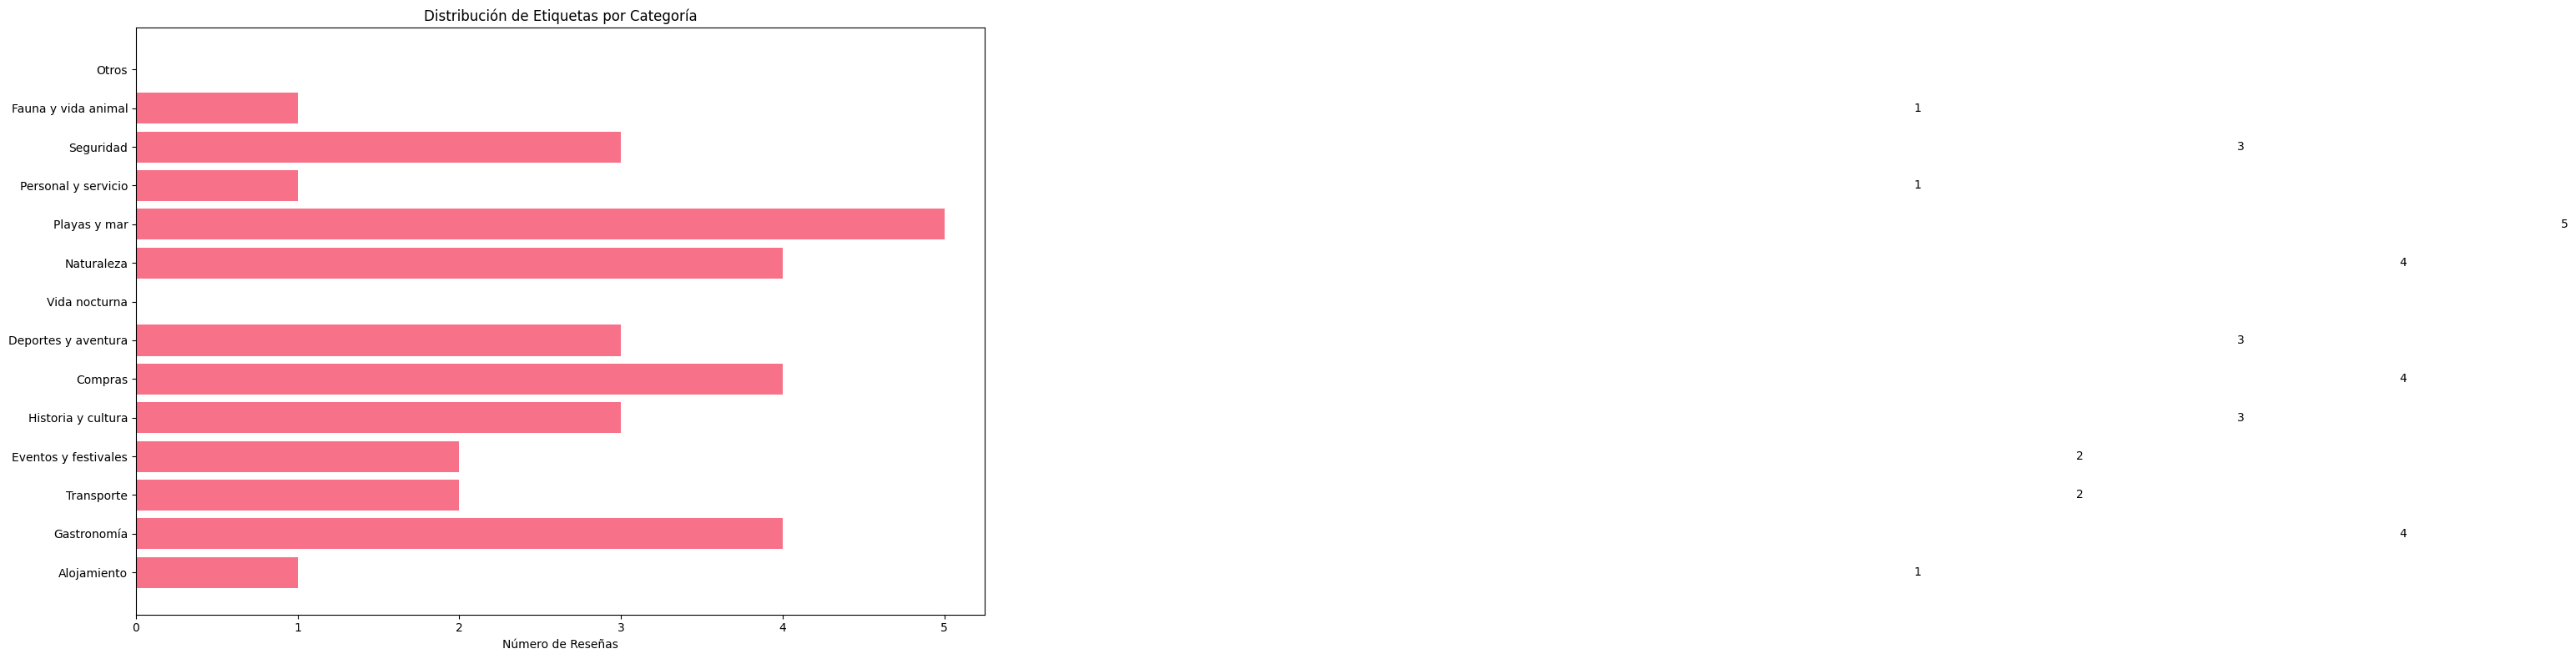

üìä DISTRIBUCI√ìN DE ETIQUETAS:
 9. Playas y mar                           5 (  0.2%)
 1. Gastronom√≠a                            4 (  0.2%)
 5. Compras                                4 (  0.2%)
 8. Naturaleza                             4 (  0.2%)
 4. Historia y cultura                     3 (  0.1%)
 6. Deportes y aventura                    3 (  0.1%)
11. Seguridad                              3 (  0.1%)
 2. Transporte                             2 (  0.1%)
 3. Eventos y festivales                   2 (  0.1%)
 0. Alojamiento                            1 (  0.0%)
10. Personal y servicio                    1 (  0.0%)
12. Fauna y vida animal                    1 (  0.0%)
 7. Vida nocturna                          0 (  0.0%)
13. Otros                                  0 (  0.0%)

Total de etiquetas asignadas: 33
Total de rese√±as: 2457
Promedio de etiquetas por rese√±a: 0.01


In [11]:
if 'labels_parsed' in df.columns:
    # Contar todas las etiquetas
    all_labels = []
    for labels_list in df['labels_parsed']:
        all_labels.extend(labels_list)
    
    label_counts = Counter(all_labels)
    
    # Crear DataFrame para visualizaci√≥n (ahora hasta categor√≠a 13)
    labels_df = pd.DataFrame([
        {'categoria_id': i, 'categoria_nombre': category_names[i], 'count': label_counts.get(i, 0)}
        for i in range(14)  # Cambiado de 13 a 14
    ])
    
    # Visualizaci√≥n 1: Gr√°fico de barras horizontal
    plt.figure(figsize=(12, 8))
    bars = plt.barh(labels_df['categoria_nombre'], labels_df['count'])
    plt.xlabel('N√∫mero de Rese√±as')
    plt.title('Distribuci√≥n de Etiquetas por Categor√≠a')
    plt.tight_layout()
    
    # A√±adir valores en las barras
    for i, bar in enumerate(bars):
        width = bar.get_width()
        if width > 0:
            plt.text(width + 10, bar.get_y() + bar.get_height()/2, 
                    f'{int(width)}', ha='left', va='center')
    
    plt.show()
    
    # Mostrar estad√≠sticas detalladas
    print("üìä DISTRIBUCI√ìN DE ETIQUETAS:")
    print("=" * 60)
    for _, row in labels_df.sort_values('count', ascending=False).iterrows():
        porcentaje = (row['count'] / len(df)) * 100
        print(f"{row['categoria_id']:2d}. {row['categoria_nombre']:<35} {row['count']:4d} ({porcentaje:5.1f}%)")
    
    print(f"\nTotal de etiquetas asignadas: {sum(label_counts.values())}")
    print(f"Total de rese√±as: {len(df)}")
    print(f"Promedio de etiquetas por rese√±a: {sum(label_counts.values()) / len(df):.2f}")

## An√°lisis de Multi-Etiquetas

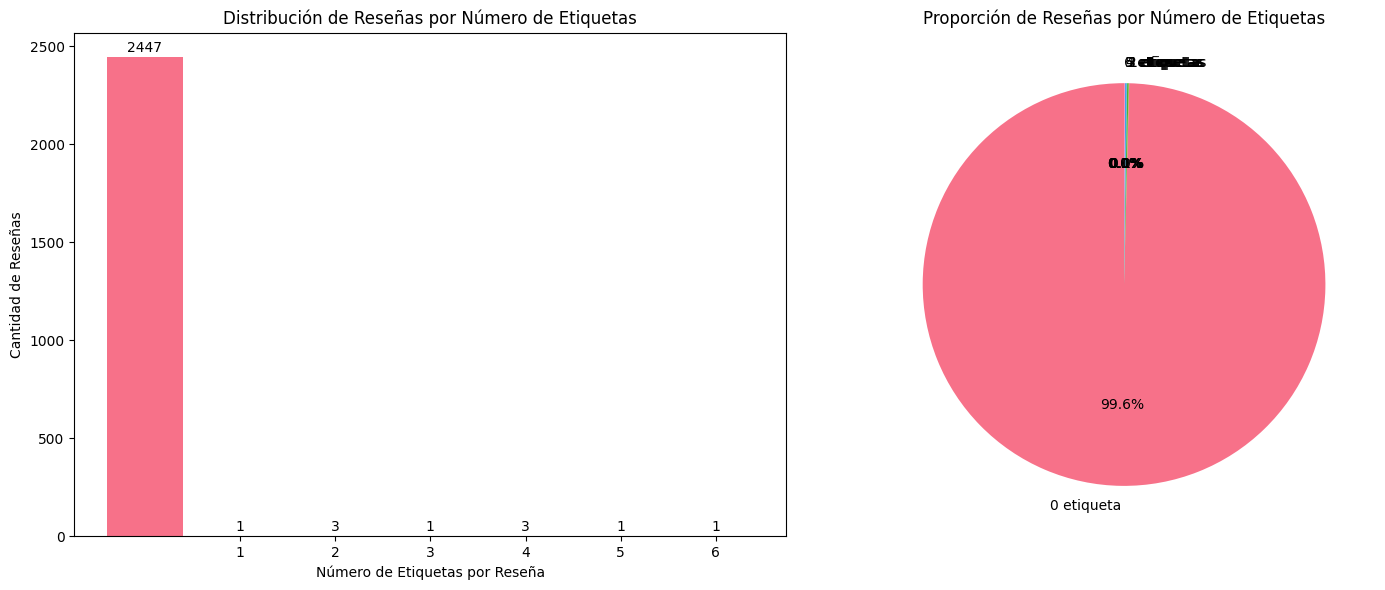

üìà AN√ÅLISIS DE MULTI-ETIQUETAS:
0 etiqueta: 2447 rese√±as ( 99.6%)
1 etiqueta:    1 rese√±as (  0.0%)
2 etiquetas:    3 rese√±as (  0.1%)
3 etiquetas:    1 rese√±as (  0.0%)
4 etiquetas:    3 rese√±as (  0.1%)
5 etiquetas:    1 rese√±as (  0.0%)
6 etiquetas:    1 rese√±as (  0.0%)

Rese√±as con m√∫ltiples etiquetas: 9
Rese√±as con una sola etiqueta: 1

üîÑ COMBINACIONES M√ÅS COMUNES (Top 10):
--------------------------------------------------
[0, 2, 10, 11] -> ['Alojamiento', 'Transporte', 'Personal y servicio', 'Seguridad'] (1 veces)
[3, 6, 9, 11] -> ['Eventos y festivales', 'Deportes y aventura', 'Playas y mar', 'Seguridad'] (1 veces)
[1, 5, 6, 8, 9, 4] -> ['Gastronom√≠a', 'Compras', 'Deportes y aventura', 'Naturaleza', 'Playas y mar', 'Historia y cultura'] (1 veces)
[2, 8] -> ['Transporte', 'Naturaleza'] (1 veces)
[11, 9] -> ['Seguridad', 'Playas y mar'] (1 veces)
[4, 8] -> ['Historia y cultura', 'Naturaleza'] (1 veces)
[1, 12, 5, 9] -> ['Gastronom√≠a', 'Fauna y vida animal', 'C

In [12]:
if 'labels_parsed' in df.columns:
    # An√°lisis de cantidad de etiquetas por rese√±a
    df['num_labels'] = df['labels_parsed'].apply(len)
    
    # Contar rese√±as por n√∫mero de etiquetas
    label_count_distribution = df['num_labels'].value_counts().sort_index()
    
    # Visualizaci√≥n: Distribuci√≥n de n√∫mero de etiquetas
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gr√°fico de barras
    bars = ax1.bar(label_count_distribution.index, label_count_distribution.values)
    ax1.set_xlabel('N√∫mero de Etiquetas por Rese√±a')
    ax1.set_ylabel('Cantidad de Rese√±as')
    ax1.set_title('Distribuci√≥n de Rese√±as por N√∫mero de Etiquetas')
    ax1.set_xticks(range(1, max(label_count_distribution.index) + 1))
    
    # A√±adir valores en las barras
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 10,
                f'{int(height)}', ha='center', va='bottom')
    
    # Gr√°fico de pie
    ax2.pie(label_count_distribution.values, labels=[f'{i} etiqueta{"s" if i>1 else ""}' for i in label_count_distribution.index],
            autopct='%1.1f%%', startangle=90)
    ax2.set_title('Proporci√≥n de Rese√±as por N√∫mero de Etiquetas')
    
    plt.tight_layout()
    plt.show()
    
    # Estad√≠sticas detalladas
    print("üìà AN√ÅLISIS DE MULTI-ETIQUETAS:")
    print("=" * 50)
    for num_labels, count in label_count_distribution.items():
        porcentaje = (count / len(df)) * 100
        print(f"{num_labels} etiqueta{'s' if num_labels > 1 else ''}: {count:4d} rese√±as ({porcentaje:5.1f}%)")
    
    print(f"\nRese√±as con m√∫ltiples etiquetas: {sum(label_count_distribution[label_count_distribution.index > 1])}")
    print(f"Rese√±as con una sola etiqueta: {label_count_distribution.get(1, 0)}")
    
    # Mostrar las combinaciones m√°s comunes de etiquetas m√∫ltiples
    multi_label_reviews = df[df['num_labels'] > 1]
    if len(multi_label_reviews) > 0:
        print(f"\nüîÑ COMBINACIONES M√ÅS COMUNES (Top 10):")
        print("-" * 50)
        combinations = multi_label_reviews['labels_parsed'].apply(tuple).value_counts().head(10)
        for combo, count in combinations.items():
            combo_names = [category_names[i] for i in combo]
            print(f"{list(combo)} -> {combo_names} ({count} veces)")

## Matriz de Co-ocurrencia de Etiquetas

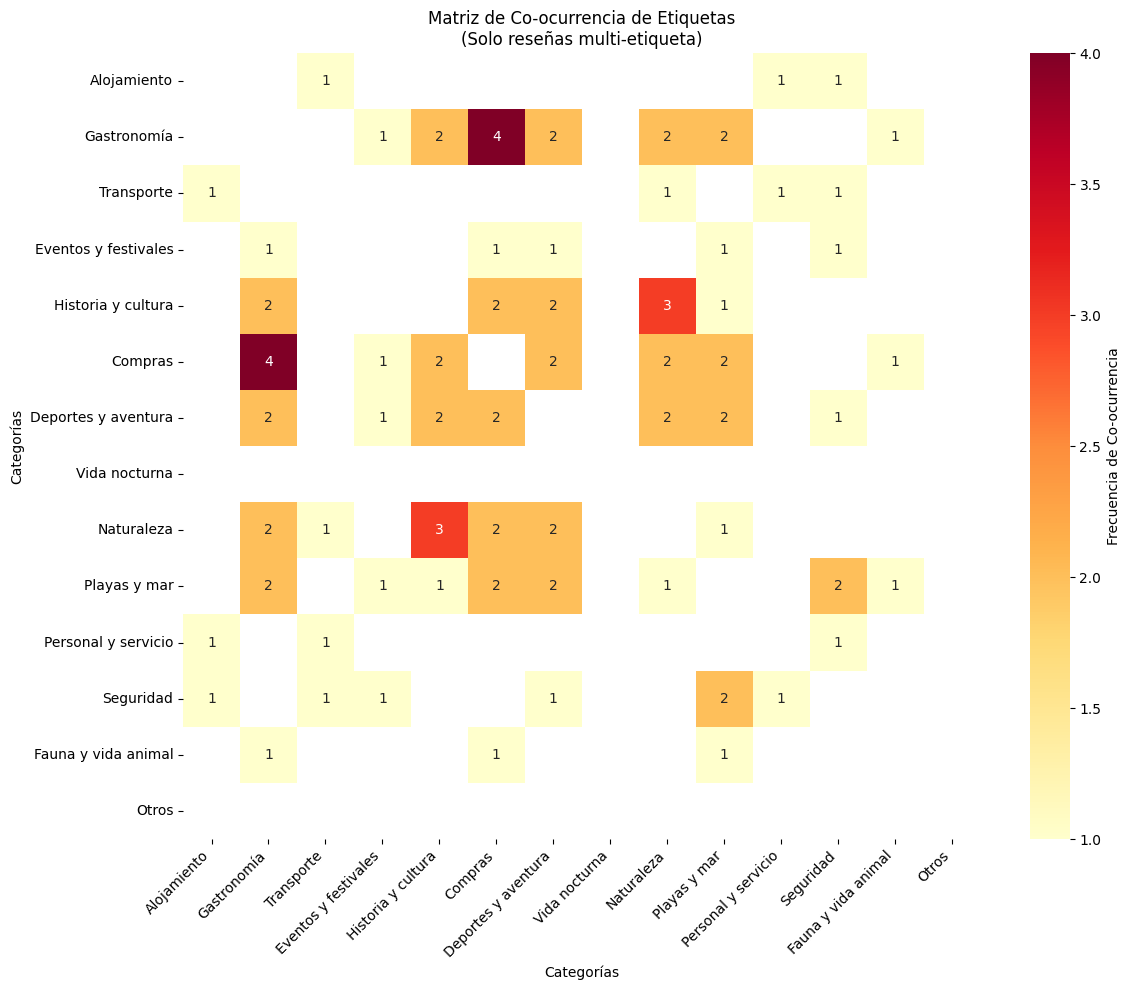

üîó CO-OCURRENCIAS M√ÅS FRECUENTES:
Gastronom√≠a ‚Üî Compras: 8 veces
Historia y cultura ‚Üî Naturaleza: 6 veces
Playas y mar ‚Üî Seguridad: 4 veces
Deportes y aventura ‚Üî Playas y mar: 4 veces
Deportes y aventura ‚Üî Naturaleza: 4 veces
Compras ‚Üî Playas y mar: 4 veces
Compras ‚Üî Naturaleza: 4 veces
Compras ‚Üî Deportes y aventura: 4 veces
Historia y cultura ‚Üî Deportes y aventura: 4 veces
Historia y cultura ‚Üî Compras: 4 veces


In [13]:
if 'labels_parsed' in df.columns:
    # Crear matriz de co-ocurrencia (ahora 14x14)
    cooccurrence_matrix = np.zeros((14, 14))
    
    for labels_list in df['labels_parsed']:
        if len(labels_list) > 1:  # Solo para rese√±as multi-etiqueta
            for i in labels_list:
                for j in labels_list:
                    if i != j and i < 14 and j < 14:  # Asegurar rango v√°lido
                        cooccurrence_matrix[i][j] += 1
    
    # Crear etiquetas abreviadas para la matriz
    short_names = [name[:20] + ('...' if len(name) > 20 else '') for name in category_names]
    
    # Visualizar matriz de co-ocurrencia
    plt.figure(figsize=(12, 10))
    mask = cooccurrence_matrix == 0  # Ocultar valores cero
    sns.heatmap(cooccurrence_matrix, 
                xticklabels=short_names,
                yticklabels=short_names,
                annot=True, 
                fmt='.0f',
                cmap='YlOrRd',
                mask=mask,
                cbar_kws={'label': 'Frecuencia de Co-ocurrencia'})
    
    plt.title('Matriz de Co-ocurrencia de Etiquetas\n(Solo rese√±as multi-etiqueta)')
    plt.xlabel('Categor√≠as')
    plt.ylabel('Categor√≠as')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Encontrar las co-ocurrencias m√°s frecuentes
    print("üîó CO-OCURRENCIAS M√ÅS FRECUENTES:")
    print("=" * 50)
    
    cooccurrences = []
    for i in range(14):  # Cambiado de 13 a 14
        for j in range(i+1, 14):  # Evitar duplicados
            if cooccurrence_matrix[i][j] + cooccurrence_matrix[j][i] > 0:
                total_cooccurrence = cooccurrence_matrix[i][j] + cooccurrence_matrix[j][i]
                cooccurrences.append((total_cooccurrence, i, j))
    
    cooccurrences.sort(reverse=True)
    
    for count, i, j in cooccurrences[:10]:  # Top 10
        print(f"{category_names[i]} ‚Üî {category_names[j]}: {int(count)} veces")

## Listado Completo de Rese√±as y sus Etiquetas

### Rese√±as Clasificadas como "Otros" [12]

In [14]:
if 'labels_parsed' in df.columns:
    # Funci√≥n para mapear etiquetas a nombres
    def labels_to_names(labels_list):
        return [category_names[label] for label in labels_list if label < len(category_names)]
    
    # Filtrar rese√±as con etiqueta [13] (Otros) - Cambiado de 12 a 13
    otros_reviews = df[df['labels_parsed'].apply(lambda x: x == [13])].copy()
    
    print("üè∑Ô∏è RESE√ëAS CLASIFICADAS COMO 'OTROS' [13]:")
    print("=" * 80)
    print(f"Total encontradas: {len(otros_reviews)}")
    print("-" * 80)
    
    if len(otros_reviews) > 0:
        for idx, (_, row) in enumerate(otros_reviews.iterrows(), 1):
            etiquetas_nombres = labels_to_names(row['labels_parsed'])
            print(f"{idx:3d}. Etiquetas: {row['labels_parsed']} -> {etiquetas_nombres}")
            print(f"     Rese√±a: {row['TituloReview']}")
            print("-" * 80)
    else:
        print("No se encontraron rese√±as clasificadas √∫nicamente como 'Otros'")
    
    # Estad√≠stica adicional sobre "Otros"
    total_with_otros = len(df[df['labels_parsed'].apply(lambda x: 13 in x)])  # Cambiado de 12 a 13
    print(f"\n‚ÑπÔ∏è  Rese√±as que incluyen etiqueta 13 (en cualquier combinaci√≥n): {total_with_otros}")
    print(f"‚ÑπÔ∏è  Rese√±as que SOLO tienen etiqueta 13: {len(otros_reviews)}")

üè∑Ô∏è RESE√ëAS CLASIFICADAS COMO 'OTROS' [13]:
Total encontradas: 0
--------------------------------------------------------------------------------
No se encontraron rese√±as clasificadas √∫nicamente como 'Otros'

‚ÑπÔ∏è  Rese√±as que incluyen etiqueta 13 (en cualquier combinaci√≥n): 0
‚ÑπÔ∏è  Rese√±as que SOLO tienen etiqueta 13: 0


### Rese√±as con Discordancias entre Modelos LLM

In [15]:
if 'labels_parsed' in df.columns and len(llm_columns) > 1:
    print("üîç RESE√ëAS CON DISCORDANCIAS ENTRE MODELOS LLM:")
    print("=" * 120)
    print(f"Modelos disponibles: {llm_columns}")
    
    # Funci√≥n para parsear etiquetas de cualquier columna
    def parse_labels_from_column(value):
        if isinstance(value, str):
            try:
                return ast.literal_eval(value)
            except:
                return [13]
        elif isinstance(value, list):
            return value
        else:
            return [13]
    
    # Encontrar rese√±as con discordancias
    discordant_reviews = []
    
    for idx, row in df.iterrows():
        if len(llm_columns) >= 2:
            # Parsear etiquetas de todos los modelos disponibles
            model_labels = {}
            for col in llm_columns:
                try:
                    # Verificar si la columna existe y tiene un valor v√°lido
                    if col in df.columns and row[col] is not None and str(row[col]).strip() != '' and str(row[col]) != 'nan':
                        model_labels[col] = set(parse_labels_from_column(row[col]))
                except Exception as e:
                    # Si hay alg√∫n error, usar etiqueta por defecto
                    model_labels[col] = set([13])
            
            # Verificar si hay discordancias comparando todos los pares
            has_discordance = False
            if len(model_labels) >= 2:
                label_sets = list(model_labels.values())
                # Comparar todos los conjuntos de etiquetas
                for i in range(len(label_sets)):
                    for j in range(i + 1, len(label_sets)):
                        if label_sets[i] != label_sets[j]:
                            has_discordance = True
                            break
                    if has_discordance:
                        break
            
            if has_discordance:
                discordant_reviews.append((idx, row, model_labels))
    
    print(f"üìä Total de discordancias encontradas: {len(discordant_reviews)}/{len(df)} ({len(discordant_reviews)/len(df)*100:.1f}%)")
    print("-" * 120)
    
    if len(discordant_reviews) > 0:
        for idx, (orig_idx, row, model_labels) in enumerate(discordant_reviews, 1):
            print(f"{idx:4d}. Rese√±a: {row['TituloReview']}")
            
            # Mostrar etiquetas de todos los modelos con discordancias
            for col, labels_set in model_labels.items():
                labels_list = sorted(list(labels_set))
                etiquetas_nombres = [category_names[label] for label in labels_list if label < len(category_names)]
                etiquetas_str = ', '.join(etiquetas_nombres)
                
                # Extraer nombre del modelo de la columna
                model_name = col.replace('TopicoConLLM_', '') if col.startswith('TopicoConLLM_') else col
                
                print(f"      {model_name:>15}: {labels_list} -> [{etiquetas_str}]")
            
            print("-" * 120)
            
            # Pausa cada 20 rese√±as para evitar output muy largo
            if idx % 20 == 0:
                print(f"\n... Mostrando {idx} de {len(discordant_reviews)} discordancias ...")
                print("Contin√∫a para ver todas...\n")
        
        print(f"\n‚úÖ An√°lisis de discordancias completado. Total mostrado: {len(discordant_reviews)} rese√±as con discordancias")
    else:
        print("‚úÖ No se encontraron discordancias entre los modelos (todos coinciden perfectamente)")

elif len(llm_columns) <= 1:
    print("‚ÑπÔ∏è Se necesitan al menos 2 modelos LLM para detectar discordancias.")
    print(f"Modelos disponibles: {llm_columns}")
else:
    print("‚ùå No se encontraron etiquetas parseadas. Ejecuta primero la secci√≥n de an√°lisis.")

üîç RESE√ëAS CON DISCORDANCIAS ENTRE MODELOS LLM:
Modelos disponibles: ['TopicoConLLM_gpt-4o-mini', 'TopicoConLLM_gpt-4.1-mini', 'TopicoConLLM_gpt-5-nano']
üìä Total de discordancias encontradas: 2455/2457 (99.9%)
------------------------------------------------------------------------------------------------------------------------
   1. Rese√±a: ¬°Divertido y seguro!. Estoy muy impresionado con Mazatl√°n, Mx. . La gente aqu√≠ es amable. . nos alojamos en El Cid resort el Moro. . Me encant√≥ el complejo, las piscinas eran divertidas y el personal de los restaurantes nos cuid√≥ mucho. . . Mis hijos tambi√©n se alojaron en el club infantil, Leti y Susan cuidaron mucho de mis dos hijos mientras disfrutaba de mi tiempo en la piscina. Tambi√©n dimos un paseo hasta el Malec√≥n, NO hay problemas durante mi paseo, la vibra era divertida y segura . . . todos conduciendo y caminando nos lo estamos pasando genial . . . Gracias Mazatl√°n este es ahora mi nuevo lugar de vacaciones. . . Volver√© 

## Resumen Final del An√°lisis de Etiquetas

In [16]:
if 'labels_parsed' in df.columns:
    print("üìä RESUMEN EJECUTIVO DEL ETIQUETADO")
    print("=" * 60)
    
    # M√©tricas generales
    total_reviews = len(df)
    total_labels_assigned = sum(len(labels) for labels in df['labels_parsed'])
    avg_labels_per_review = total_labels_assigned / total_reviews
    
    # Distribuci√≥n por n√∫mero de etiquetas
    single_label = len(df[df['num_labels'] == 1])
    multi_label = len(df[df['num_labels'] > 1])
    max_labels = df['num_labels'].max()
    
    # Categor√≠a m√°s y menos asignada
    label_counts = Counter()
    for labels in df['labels_parsed']:
        for label in labels:
            label_counts[label] += 1
    
    most_common_label = label_counts.most_common(1)[0]
    least_common_labels = [label for label, count in label_counts.items() if count == min(label_counts.values())]
    
    # Casos especiales (cambiado de 12 a 13)
    otros_only = len(df[df['labels_parsed'].apply(lambda x: x == [13])])
    has_otros = len(df[df['labels_parsed'].apply(lambda x: 13 in x)])
    
    print(f"üìà ESTAD√çSTICAS GENERALES:")
    print(f"   ‚Ä¢ Total de rese√±as procesadas: {total_reviews:,}")
    print(f"   ‚Ä¢ Total de etiquetas asignadas: {total_labels_assigned:,}")
    print(f"   ‚Ä¢ Promedio de etiquetas por rese√±a: {avg_labels_per_review:.2f}")
    print(f"   ‚Ä¢ M√°ximo de etiquetas en una rese√±a: {max_labels}")
    
    print(f"\nüè∑Ô∏è  DISTRIBUCI√ìN DE ETIQUETADO:")
    print(f"   ‚Ä¢ Rese√±as con una sola etiqueta: {single_label:,} ({single_label/total_reviews*100:.1f}%)")
    print(f"   ‚Ä¢ Rese√±as multi-etiqueta: {multi_label:,} ({multi_label/total_reviews*100:.1f}%)")
    
    print(f"\nüéØ CATEGOR√çAS M√ÅS RELEVANTES:")
    print(f"   ‚Ä¢ M√°s asignada: {category_names[most_common_label[0]]} ({most_common_label[1]:,} veces)")
    
    if least_common_labels:
        least_names = [category_names[label] for label in least_common_labels]
        print(f"   ‚Ä¢ Menos asignada(s): {', '.join(least_names)} ({min(label_counts.values())} veces)")
    
    print(f"\n‚ö†Ô∏è  CASOS ESPECIALES:")
    print(f"   ‚Ä¢ Rese√±as clasificadas solo como 'Otros': {otros_only}")
    print(f"   ‚Ä¢ Rese√±as que incluyen 'Otros': {has_otros}")
    
    # Calidad del etiquetado
    quality_score = (1 - (otros_only / total_reviews)) * 100
    print(f"\n‚úÖ INDICADOR DE CALIDAD DEL ETIQUETADO: {quality_score:.1f}%")
    print(f"   (Basado en rese√±as NO clasificadas √∫nicamente como 'Otros')")
    
    # Recomendaciones
    print(f"\nüí° OBSERVACIONES:")
    if otros_only / total_reviews > 0.05:  # Si m√°s del 5% son "Otros"
        print(f"   ‚ö†Ô∏è  Alto porcentaje de rese√±as 'Otros' ({otros_only/total_reviews*100:.1f}%)")
        print(f"      Considera revisar estas rese√±as para posibles mejoras en el prompt")
    
    if avg_labels_per_review > 2:
        print(f"   ‚ÑπÔ∏è  Promedio alto de etiquetas por rese√±a ({avg_labels_per_review:.2f})")
        print(f"      El modelo tiende a ser inclusivo en la clasificaci√≥n")
    
    if multi_label / total_reviews > 0.3:
        print(f"   ‚úÖ Buen uso de clasificaci√≥n multi-etiqueta ({multi_label/total_reviews*100:.1f}%)")
    
    print("\n" + "=" * 60)

üìä RESUMEN EJECUTIVO DEL ETIQUETADO
üìà ESTAD√çSTICAS GENERALES:
   ‚Ä¢ Total de rese√±as procesadas: 2,457
   ‚Ä¢ Total de etiquetas asignadas: 33
   ‚Ä¢ Promedio de etiquetas por rese√±a: 0.01
   ‚Ä¢ M√°ximo de etiquetas en una rese√±a: 6

üè∑Ô∏è  DISTRIBUCI√ìN DE ETIQUETADO:
   ‚Ä¢ Rese√±as con una sola etiqueta: 1 (0.0%)
   ‚Ä¢ Rese√±as multi-etiqueta: 9 (0.4%)

üéØ CATEGOR√çAS M√ÅS RELEVANTES:
   ‚Ä¢ M√°s asignada: Playas y mar (5 veces)
   ‚Ä¢ Menos asignada(s): Alojamiento, Personal y servicio, Fauna y vida animal (1 veces)

‚ö†Ô∏è  CASOS ESPECIALES:
   ‚Ä¢ Rese√±as clasificadas solo como 'Otros': 0
   ‚Ä¢ Rese√±as que incluyen 'Otros': 0

‚úÖ INDICADOR DE CALIDAD DEL ETIQUETADO: 100.0%
   (Basado en rese√±as NO clasificadas √∫nicamente como 'Otros')

üí° OBSERVACIONES:



## Comparaci√≥n entre Modelos LLM

Esta secci√≥n compara los resultados de etiquetado entre diferentes modelos LLM para identificar diferencias en la clasificaci√≥n.

In [17]:
if len(llm_label_columns) > 1:
    print("üîÑ COMPARACI√ìN ENTRE MODELOS:")
    print("=" * 80)
    
    # Funci√≥n universal para parsear etiquetas para comparaci√≥n
    def parse_model_labels_comparison(label_value):
        """Parsea etiquetas de cualquier formato para comparaci√≥n"""
        if isinstance(label_value, str):
            try:
                parsed = ast.literal_eval(label_value)
                # Si es lista de diccionarios (justificado), extraer IDs
                if isinstance(parsed, list) and len(parsed) > 0 and isinstance(parsed[0], dict):
                    return [item.get('label_id', 13) for item in parsed]
                elif isinstance(parsed, list):
                    return parsed
                else:
                    return [13]
            except:
                return [13]
        elif isinstance(label_value, list):
            if len(label_value) > 0 and isinstance(label_value[0], dict):
                return [item.get('label_id', 13) for item in label_value]
            else:
                return label_value
        else:
            return [13]
    
    # Estad√≠sticas por modelo
    for col in llm_label_columns:
        if col in df.columns:
            model_name = col.replace('TopicoConLLM_', '') if col.startswith('TopicoConLLM_') else col
            
            # Determinar el tipo de modelo
            if model_name in MODELS_BASIC:
                model_type = "B√°sico"
            elif model_name in MODELS_JUSTIFIED:
                model_type = "Justificado" 
            else:
                model_type = "Desconocido"
            
            # Parsear etiquetas de este modelo usando funci√≥n universal
            df[f'{col}_parsed'] = df[col].apply(parse_model_labels_comparison)
            
            # Calcular estad√≠sticas
            total_labels = sum(len(labels) for labels in df[f'{col}_parsed'])
            avg_labels = total_labels / len(df)
            multi_label_pct = (sum(1 for labels in df[f'{col}_parsed'] if len(labels) > 1) / len(df)) * 100
            otros_only_count = sum(1 for labels in df[f'{col}_parsed'] if labels == [13])
            
            print(f"\nüìä MODELO: {model_name} ({model_type})")
            print(f"   ‚Ä¢ Promedio de etiquetas por rese√±a: {avg_labels:.2f}")
            print(f"   ‚Ä¢ Rese√±as multi-etiqueta: {multi_label_pct:.1f}%")
            print(f"   ‚Ä¢ Rese√±as solo 'Otros': {otros_only_count} ({otros_only_count/len(df)*100:.1f}%)")
    
    # Comparar diferencias entre modelos (mapear todos al formato b√°sico)
    if len(llm_label_columns) >= 2:
        print(f"\nüîç AN√ÅLISIS DE DIFERENCIAS ENTRE MODELOS:")
        print("-" * 60)
        
        # Comparar cada par de modelos
        for i in range(len(llm_label_columns)):
            for j in range(i + 1, len(llm_label_columns)):
                col1, col2 = llm_label_columns[i], llm_label_columns[j]
                model1 = col1.replace('TopicoConLLM_', '') 
                model2 = col2.replace('TopicoConLLM_', '')
                
                print(f"\nüîÑ Comparando: {model1} vs {model2}")
                
                differences_count = 0
                examples_shown = 0
                max_examples = 5  # Limitar ejemplos mostrados
                
                for idx, row in df.iterrows():
                    try:
                        labels1 = parse_model_labels_comparison(row[col1])
                        labels2 = parse_model_labels_comparison(row[col2])
                    except:
                        labels1, labels2 = [13], [13]
                    
                    if set(labels1) != set(labels2):
                        differences_count += 1
                        if examples_shown < max_examples:
                            names1 = [category_names[l] for l in labels1 if l < len(category_names)]
                            names2 = [category_names[l] for l in labels2 if l < len(category_names)]
                            print(f"   Ej.{examples_shown + 1}: {row['TituloReview'][:45]}...")
                            print(f"      {model1}: {labels1} -> {names1}")
                            print(f"      {model2}: {labels2} -> {names2}")
                            examples_shown += 1
                
                print(f"   üìä Total diferencias: {differences_count}/{len(df)} ({differences_count/len(df)*100:.1f}%)")
    
    # Limpiar columnas temporales de parsing
    for col in llm_label_columns:
        temp_col = f'{col}_parsed'
        if temp_col in df.columns:
            df.drop(temp_col, axis=1, inplace=True)

else:
    print("‚ÑπÔ∏è Solo hay un modelo disponible. Ejecuta el etiquetado con diferentes modelos para comparar.")

üîÑ COMPARACI√ìN ENTRE MODELOS:

üìä MODELO: gpt-4o-mini (B√°sico)
   ‚Ä¢ Promedio de etiquetas por rese√±a: 1.91
   ‚Ä¢ Rese√±as multi-etiqueta: 58.2%
   ‚Ä¢ Rese√±as solo 'Otros': 25 (1.0%)

üìä MODELO: gpt-4.1-mini (B√°sico)
   ‚Ä¢ Promedio de etiquetas por rese√±a: 2.28
   ‚Ä¢ Rese√±as multi-etiqueta: 72.8%
   ‚Ä¢ Rese√±as solo 'Otros': 10 (0.4%)

üìä MODELO: gpt-5-nano (Justificado)
   ‚Ä¢ Promedio de etiquetas por rese√±a: 0.01
   ‚Ä¢ Rese√±as multi-etiqueta: 0.4%
   ‚Ä¢ Rese√±as solo 'Otros': 0 (0.0%)

üîç AN√ÅLISIS DE DIFERENCIAS ENTRE MODELOS:
------------------------------------------------------------

üîÑ Comparando: gpt-4o-mini vs gpt-4.1-mini
   Ej.1: ¬°Divertido y seguro!. Estoy muy impresionado ...
      gpt-4o-mini: [0, 10, 11] -> ['Alojamiento', 'Personal y servicio', 'Seguridad']
      gpt-4.1-mini: [0, 1, 10, 11] -> ['Alojamiento', 'Gastronom√≠a', 'Personal y servicio', 'Seguridad']
   Ej.2: Un mes en Mazatl√°n. Acabamos de pasar un mes ...
      gpt-4o-mini: 

## An√°lisis de Justificaciones del Modelo gpt-5-nano

Esta secci√≥n muestra las justificaciones detalladas proporcionadas por el modelo gpt-5-nano para cada etiqueta asignada.

In [18]:
import pandas as pd

# Buscar columnas de justificaciones de gpt-5-nano
justification_columns = [col for col in df.columns if col.startswith('JustificacionLLM_gpt-5-nano')]

if justification_columns:
    justification_col = justification_columns[0]  # Usar la primera (deber√≠a ser √∫nica)
    print(f"üîç AN√ÅLISIS DE JUSTIFICACIONES: {justification_col}")
    print("=" * 80)
    
    # Funci√≥n para mostrar justificaciones de manera legible
    def display_justifications(review_idx, max_text_length=80):
        """Muestra las justificaciones de una rese√±a espec√≠fica"""
        if justification_col in df.columns and review_idx < len(df):
            review_text = df.iloc[review_idx]['TituloReview']
            justifications_data = df.iloc[review_idx][justification_col]
            
            print(f"üìù Rese√±a #{review_idx + 1}:")
            print(f"   Texto: {review_text}")
            print(f"   Justificaciones:")
            
            # Parsear justificaciones si est√°n en formato string
            if isinstance(justifications_data, str):
                try:
                    justifications_data = ast.literal_eval(justifications_data)
                except:
                    print("   ‚ùå Error al parsear justificaciones")
                    return
            
            if isinstance(justifications_data, dict):
                for label_id, details in justifications_data.items():
                    if isinstance(details, dict):
                        label_name = details.get('label_name', f'Categor√≠a {label_id}')
                        justification = details.get('justification', 'Sin justificaci√≥n')
                        
                        # Truncar justificaci√≥n si es muy larga
                        if len(justification) > max_text_length:
                            justification_display = justification[:max_text_length] + "..."
                        else:
                            justification_display = justification
                            
                        print(f"      ‚Ä¢ {label_id}: {label_name}")
                        print(f"        Justificaci√≥n: \"{justification_display}\"")
                print()
            else:
                print("   ‚ö†Ô∏è Formato de justificaciones no reconocido")
        else:
            print(f"   ‚ùå No se encontraron datos para la rese√±a #{review_idx + 1}")
    
    # Mostrar estad√≠sticas generales de justificaciones
    if justification_col in df.columns:
        print("üìä ESTAD√çSTICAS DE JUSTIFICACIONES:")
        print("-" * 60)
        
        total_with_justifications = 0
        total_justification_entries = 0
        justification_lengths = []
        
        for idx, row in df.iterrows():
            justifications_data = row[justification_col]
            
            if pd.notna(justifications_data):
                # Parsear si es string
                if isinstance(justifications_data, str):
                    try:
                        justifications_data = ast.literal_eval(justifications_data)
                    except:
                        continue
                
                if isinstance(justifications_data, dict) and len(justifications_data) > 0:
                    total_with_justifications += 1
                    total_justification_entries += len(justifications_data)
                    
                    # Recopilar longitudes de justificaciones
                    for details in justifications_data.values():
                        if isinstance(details, dict) and 'justification' in details:
                            justification_lengths.append(len(details['justification']))
        
        print(f"‚Ä¢ Total de rese√±as con justificaciones: {total_with_justifications}")
        print(f"‚Ä¢ Total de etiquetas justificadas: {total_justification_entries}")
        
        if justification_lengths:
            avg_length = np.mean(justification_lengths)
            print(f"‚Ä¢ Longitud promedio de justificaciones: {avg_length:.1f} caracteres")
            print(f"‚Ä¢ Longitud m√≠nima: {min(justification_lengths)} caracteres")
            print(f"‚Ä¢ Longitud m√°xima: {max(justification_lengths)} caracteres")
        
        print(f"\nüîç EJEMPLOS DE JUSTIFICACIONES (Primeras 10 rese√±as):")
        print("-" * 80)
        for i in range(min(10, len(df))):
            display_justifications(i, max_text_length=100)
        
        # An√°lisis por categor√≠a
        print(f"\nüìã AN√ÅLISIS DE JUSTIFICACIONES POR CATEGOR√çA:")
        print("-" * 60)
        
        category_justification_count = Counter()
        for idx, row in df.iterrows():
            justifications_data = row[justification_col]
            
            if pd.notna(justifications_data):
                if isinstance(justifications_data, str):
                    try:
                        justifications_data = ast.literal_eval(justifications_data)
                    except:
                        continue
                
                if isinstance(justifications_data, dict):
                    for label_id in justifications_data.keys():
                        try:
                            category_justification_count[int(label_id)] += 1
                        except:
                            pass
        
        print("Categor√≠as m√°s justificadas:")
        for label_id, count in category_justification_count.most_common(10):
            category_name = category_names[label_id] if label_id < len(category_names) else f"Categor√≠a {label_id}"
            print(f"   {label_id}: {category_name} -> {count} justificaciones")
        
    else:
        print(f"‚ùå Columna de justificaciones no encontrada: {justification_col}")

elif 'gpt-5-nano' in [col.replace('TopicoConLLM_', '') for col in llm_label_columns]:
    print("‚ö†Ô∏è Modelo gpt-5-nano encontrado pero sin columna de justificaciones.")
    print("Esto puede indicar que el modelo no se ha ejecutado con el enfoque justificado a√∫n.")
    
else:
    print("‚ÑπÔ∏è Modelo gpt-5-nano no encontrado en las columnas LLM.")
    print("Ejecuta primero el procesamiento para generar las justificaciones.")

‚ö†Ô∏è Modelo gpt-5-nano encontrado pero sin columna de justificaciones.
Esto puede indicar que el modelo no se ha ejecutado con el enfoque justificado a√∫n.


## Implementaci√≥n de Producci√≥n

Para la implementaci√≥n definitiva usando **Batch API de OpenAI** con etiquetado justificado y gpt-4o-mini, consulta:

### üìÅ **Notebook 10: `10-etiquetado-produccion-batch-api.ipynb`**

**Ventajas de la implementaci√≥n en el Notebook 10:**
- üí∞ **50% reducci√≥n de costos** vs API regular
- üöÄ **Sin l√≠mites de rate limiting** - procesa miles de rese√±as simult√°neamente
- ‚ö° **Procesamiento as√≠ncrono** - ideal para datasets grandes
- üìä **Resultados estructurados** con justificaciones completas
- üîÑ **Manejo robusto de errores** con reintentos autom√°ticos

**Este notebook (09) sirve como:**
- üî¨ **Exploraci√≥n y comparaci√≥n** de diferentes modelos LLM
- üìä **An√°lisis de resultados** y visualizaciones detalladas
- üß™ **Experimentaci√≥n** con prompts y configuraciones
- üìà **Evaluaci√≥n de calidad** del etiquetado